In [2]:
%matplotlib inline

Installation instructions

conda create -n astra jupyter

source activate astra

conda install -c https://conda.anaconda.org/astra-toolbox astra-toolbox

conda install -c dgursoy tomopy

conda install  numpy==1.9.3 h5py matplotlib cudatoolkit opencv

In [1]:
import os
import json

import numpy as np
import pylab as plt

import h5py
import cv2

from pprint import pprint
from glob import glob

import dask.array as da

import sys
sys.path.insert(0, '/opt/usr/python/')

In [3]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = unicode(index or '?')

In [4]:
# file_id = 'a789cd0f-f718-4ff2-9f89-01b015cd13c8'
# file_id = '8eee41d5-8c4e-49d8-a496-898200bed0d5'
# file_id = '5e233c53-2925-4774-b680-0d71f73eb8e1'
# file_id = 'f3e80ec9-324f-41bb-a93e-605bcbbcde98'
# file_id = '1032b444-3eeb-4b30-90c6-64f571dc25de'
# file_id = '7efa3f65-ec22-4981-a0dd-40797b15db69'
file_id = 'e6fe4ea1-79ef-47bc-bc06-d1d62c4fa03d'
data_dir = '/diskmnt/fast/makov/robotom/'
data_file = os.path.join(data_dir, file_id+'.h5')
if not os.path.isfile(data_file):
    !wget  http://10.0.7.153:5006/storage/experiments/{file_id}/hdf5 -O {data_file}

In [5]:
frame_count = len(h5py.File(data_file,'r')['data'])
print frame_count
s=[]
with h5py.File(data_file,'r') as h5f:
     for k,v in log_progress(h5f['data'].items()):
#         x = v.value
        s.append([int(k), np.sum(np.log(v.value+1))])


905


KeyboardInterrupt: 

In [ ]:
y = [d[1] for d in s]
x = [d[0] for d in s]
plt.figure(figsize=(7,5))
plt.plot(x,y,'o')
# plt.gca().set_ylim([np.min(y)*0.9,np.max(y)*1.05])
plt.grid(True)
plt.ylabel('Frame number')
plt.ylabel('Total intensity')
plt.show()

In [ ]:
with h5py.File(data_file,'r') as h5f:
    e = h5f['data']
    print len(e)

In [5]:
# Загружаем пустые пучки и темновой ток
with h5py.File(data_file,'r') as h5f:
    empty_images_count = len(h5f['empty'])
    empty_images = None
    empty_file_number = 0
    for k,v in log_progress(h5f['empty'].items()):
        if empty_images is None:
            empty_images = np.zeros(shape=(empty_images_count, v.shape[1], v.shape[0]), dtype='float32')
        attributes = json.loads(v.attrs.items()[0][1])[0]
        exposure = attributes['frame']['image_data']['exposure']
        empty_images[empty_file_number] = np.flipud(v.value.astype('float32').swapaxes(0,1)) / exposure
        empty_file_number = empty_file_number + 1
    
    dark_images_count = len(h5f['dark'])
    dark_images = None
    dark_file_number = 0
    for k,v in log_progress(h5f['dark'].items()):
        if dark_images is None:
            dark_images = np.zeros(shape=(dark_images_count, v.shape[1], v.shape[0]), dtype='float32')
        
        attributes = json.loads(v.attrs.items()[0][1])[0]
        exposure = int(attributes['frame']['image_data']['exposure'])
        dark_images[dark_file_number] = np.flipud(v.value.astype('float32').swapaxes(0,1)) / exposure
        dark_file_number = dark_file_number + 1

In [6]:
# считаем среднее значение
empty_image = empty_images.sum(axis=0)/len(empty_images)
dark_image = dark_images.sum(axis=0)/len(empty_images)

%xdel empty_images
%xdel dark_images

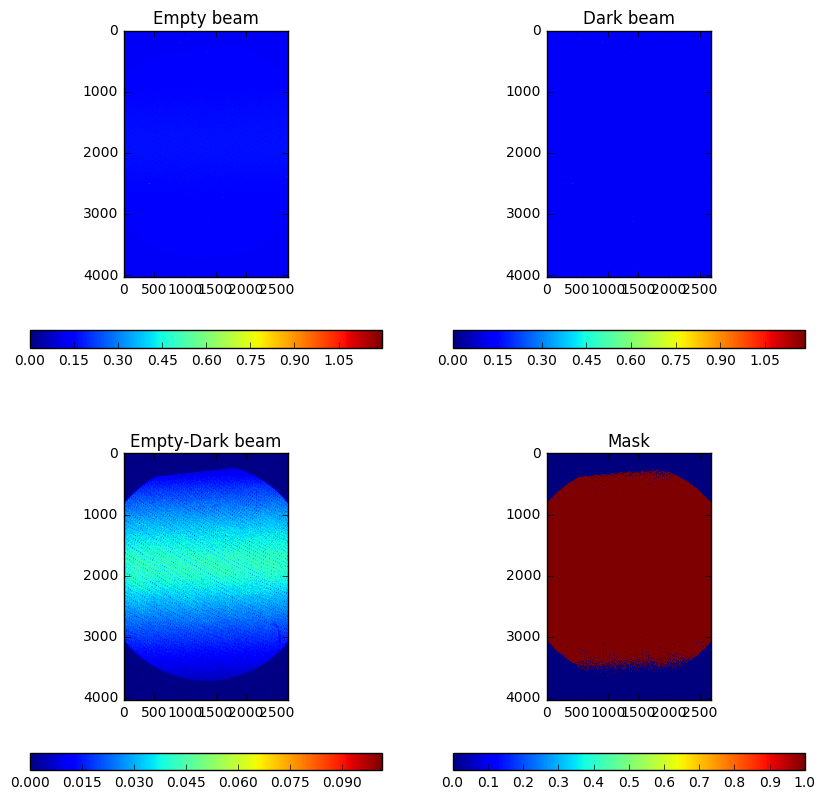

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(empty_image, vmin=0)
plt.colorbar(orientation='horizontal')
plt.title('Empty beam')

plt.subplot(222)
plt.imshow(dark_image, vmin=0)
plt.colorbar(orientation='horizontal')
plt.title('Dark beam')

empty_beam = empty_image-dark_image
plt.subplot(223)
plt.imshow(empty_beam, vmin=0)
plt.colorbar(orientation='horizontal')
plt.title('Empty-Dark beam')

mask = empty_beam > 0.01
plt.subplot(224)
plt.imshow(mask)
plt.colorbar(orientation='horizontal')
plt.title('Mask')
#TODO: Check thresshold automaticaly
# plt.plot([sum(empty_beam > i) for i in np.arange(100)])

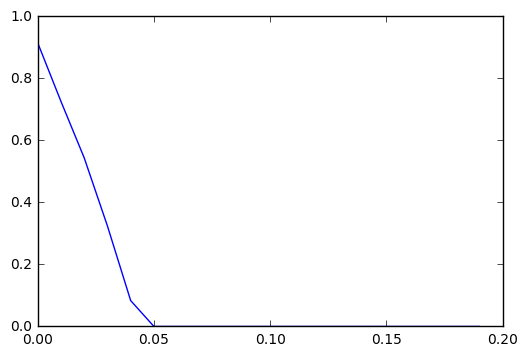

In [8]:
# try find automatic threshold for mask
x_range = np.arange(0,0.2,0.01)
plt.plot(x_range, [(empty_beam > x).sum().astype('float32')/np.prod(empty_beam.shape) for x in x_range])

1200 2656
10 2677


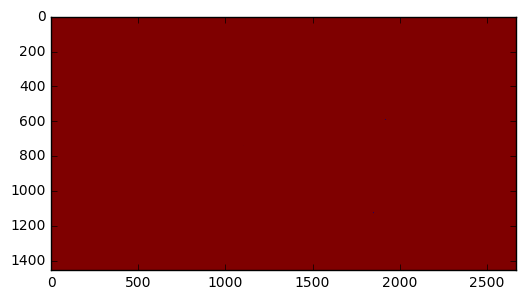

In [9]:
#build mask
threshold = 100
mask_x_profile = mask.sum(axis=1)
mask_x_min = np.argwhere(mask_x_profile>threshold).min()+900 # up border
mask_x_max = np.argwhere(mask_x_profile>threshold).max()-900 # bottom border
print mask_x_min, mask_x_max

mask_y_profile = mask.sum(axis=0)
mask_y_min = np.argwhere(mask_y_profile>threshold).min()+10 # left border
mask_y_max = np.argwhere(mask_y_profile>threshold).max()-10 # right border
print mask_y_min, mask_y_max

plt.imshow(mask[mask_x_min:mask_x_max,mask_y_min:mask_y_max])

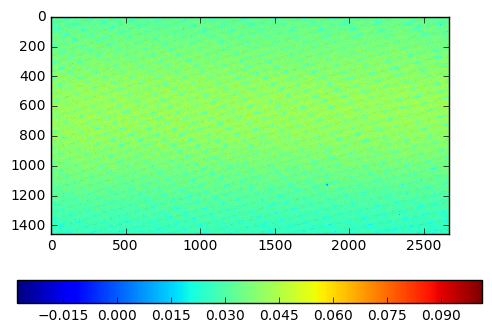

In [10]:
mask_new = np.copy(mask[mask_x_min:mask_x_max,mask_y_min:mask_y_max])
empty_beam = empty_beam[mask_x_min:mask_x_max,mask_y_min:mask_y_max]
dark_image = dark_image[mask_x_min:mask_x_max,mask_y_min:mask_y_max]

plt.imshow(empty_beam)
plt.colorbar(orientation='horizontal')

In [12]:
# Загружаем кадры с даннымии
#TODO: добавить поддержку, когда много кадров на одном угле
with h5py.File(data_file,'r') as h5f:
    data_images_count = len(h5f['data'])
    data_images = None
    data_file_number = 0
    data_angles = None
    for k,v in log_progress(h5f['data'].items()):
        if data_images is None:
            data_images = np.zeros(shape=(data_images_count,
                                          mask_x_max-mask_x_min,
                                          mask_y_max-mask_y_min
                                          ),
                                   dtype='float32')

        if data_angles is None:
            data_angles = np.zeros(shape=(data_images_count,), dtype='float32')

        attributes = json.loads(v.attrs.items()[0][1])[0]
        exposure = attributes['frame']['image_data']['exposure']
        data_angles[data_file_number] = attributes['frame']['object']['angle position']
        # вырезаем область под маску
        data_images[data_file_number] = np.flipud(
            v[mask_y_min:mask_y_max,-mask_x_max:-mask_x_min].astype('float32').swapaxes(0,1)) / exposure
        data_file_number = data_file_number + 1

In [13]:
uniq_angles = list(set(data_angles))
uniq_data_images = np.zeros(shape=(len(uniq_angles), data_images.shape[1], data_images.shape[2]))

for ua_id, ua in enumerate(uniq_angles):
    indexes = np.argwhere(data_angles==uniq_angles[ua_id])
    tmp_images = data_images[indexes]
    tmp_images = np.squeeze(tmp_images)
    mean_image = np.mean(tmp_images, axis=0)
    uniq_data_images[ua_id] = mean_image    

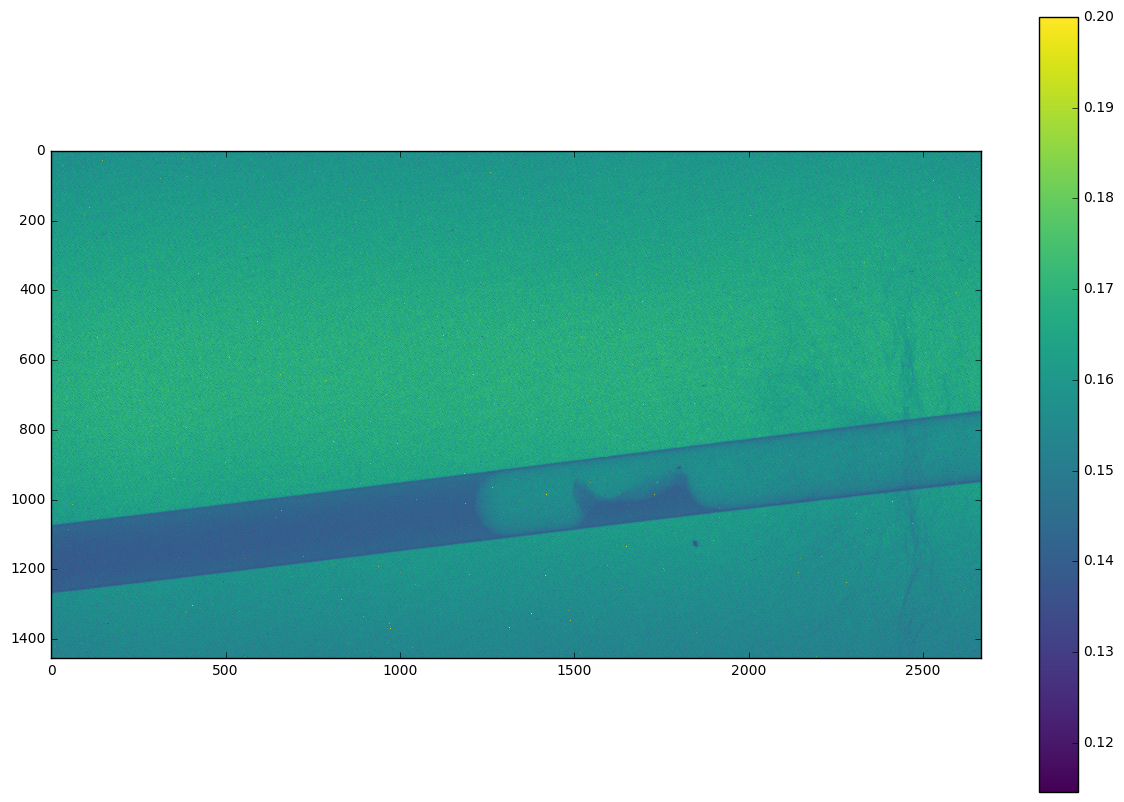

In [14]:
plt.figure(figsize=(15,10))
plt.imshow(uniq_data_images[0], vmax=0.2, cmap=plt.cm.viridis)
plt.colorbar()

In [15]:
# remove dark current from data frames and remove min/max values
# data_beam = data_images - dark_image
data_beam = uniq_data_images - dark_image
data_beam[data_beam <= 0] = 1e-8
empty_beam[empty_beam <= 0] = 1e-8
# %xdel data_images

In [16]:
%xdel data_images

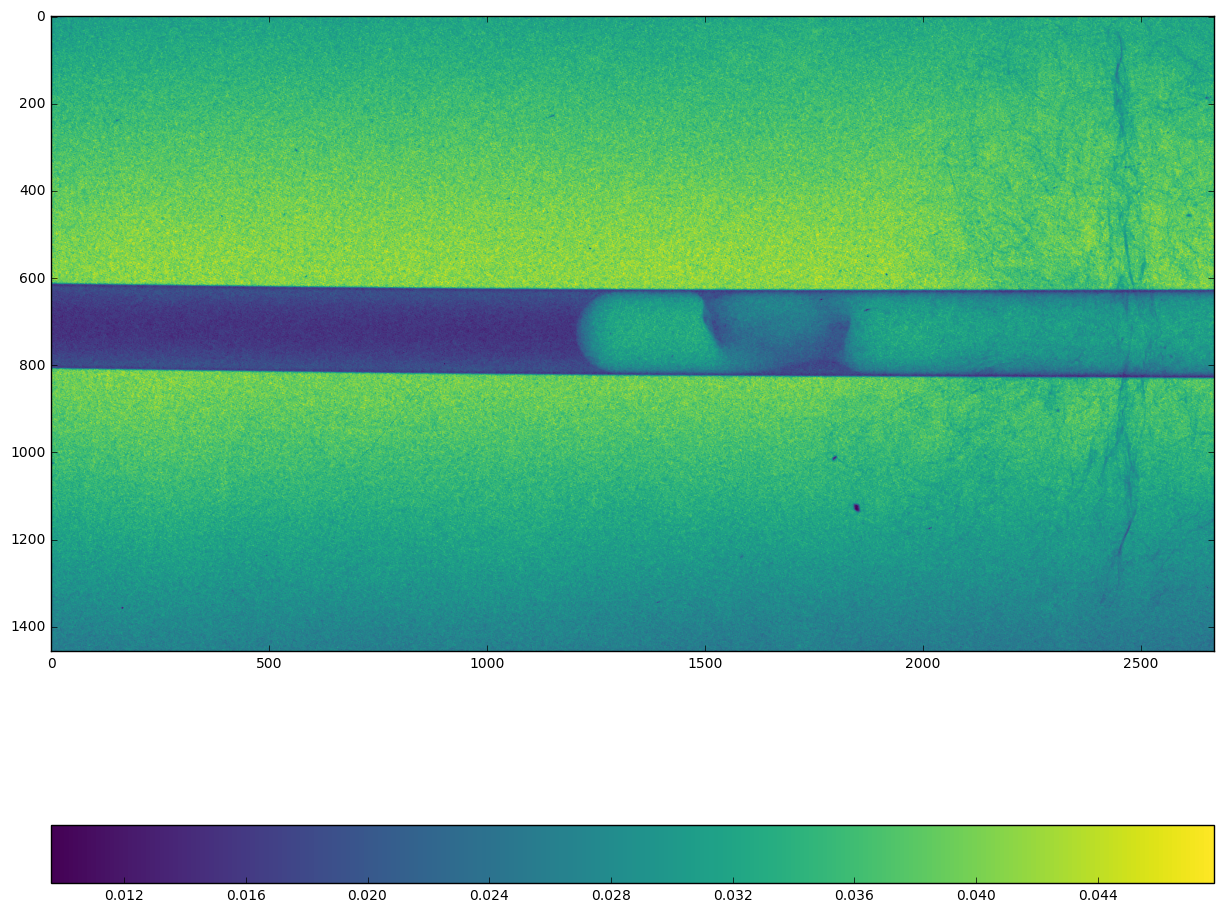

In [17]:
from scipy.ndimage import median_filter
plt.figure(figsize=(15,15))
plt.imshow(median_filter(data_beam[100],3),cmap=plt.cm.viridis)
plt.colorbar(orientation='horizontal')

In [18]:
#normalize data frames and calculate sinograms
data_beam/=empty_beam
data_beam*=mask_new
data_beam[data_beam>1] = 1
data_beam[np.isclose(data_beam,0)]=1
data_beam[data_beam<1e-6] = 1e-6

In [19]:
sinogram = -np.log(data_beam)

In [20]:
%xdel data_beam
%xdel uniq_data_images

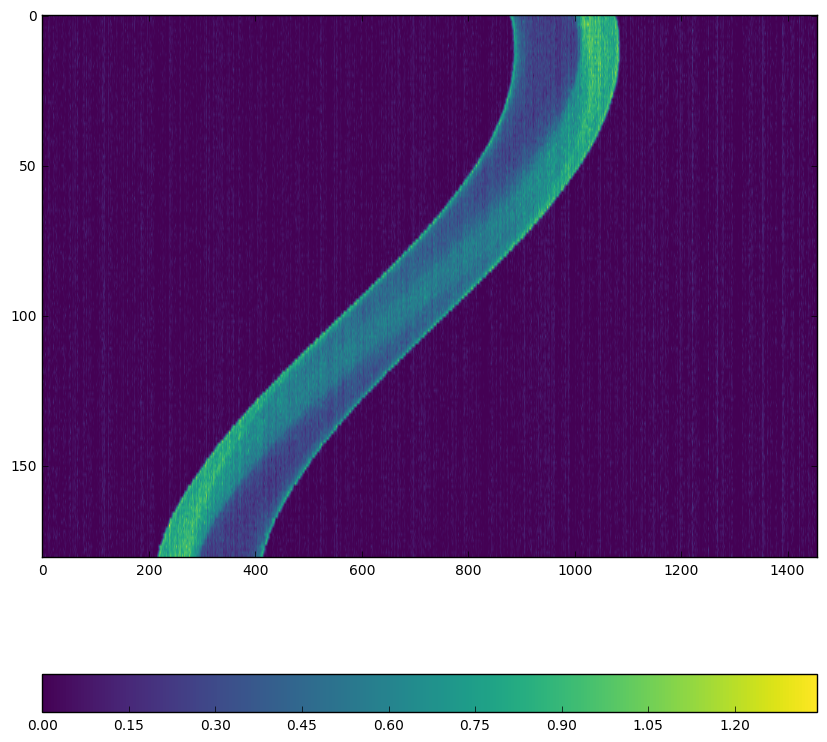

In [21]:
tmp_sinogram = sinogram[np.argsort(uniq_angles),:,1600 ]

plt.figure(figsize=(10,10))
plt.imshow(tmp_sinogram, cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')

In [22]:
import cv2
# seraching detector rotation angle
position_0 = np.argwhere(np.isclose(uniq_angles, 0, atol=0.05))[0][0]
print data_angles[position_0], position_0

position_180 = np.argwhere(np.isclose(uniq_angles, 180, atol=0.05))[0][0]
print data_angles[position_180], position_180

def get_region(position):
    return median_filter(sinogram[position,:,:],3)

def cv_rotate(x, angle):
    """
    Rotate square array using OpenCV2 around center of the array
    :param x: 2d numpy array
    :param angle: angle in degrees
    :return: rotated array
    """
    x_center = tuple(
        np.array((x.shape[1], x.shape[0]), dtype='float32') / 2.0 - 0.5)
    rot_mat = cv2.getRotationMatrix2D(x_center, angle, 1.0)
    xro = cv2.warpAffine(
        x, rot_mat, (x.shape[1], x.shape[0]), flags=cv2.INTER_LINEAR)
    return xro


data_0 = np.rot90(get_region(position_0))
data_180 = np.rot90(get_region(position_180))

0.0 0
20.9981 21


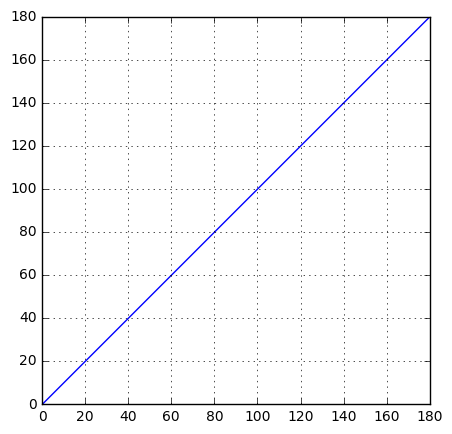

In [23]:
plt.figure(figsize=(5,5))
plt.plot(sorted(uniq_angles))
plt.grid(True)
plt.show()

In [24]:
from scipy.optimize import minimize
def f(x):
    alfa= x[0]
    shift = int(x[1])
    if shift >= 0:
        t = enp.fliplr(cv_rotate(data_180[:,shift:],alfa))-cv_rotate(data_0[:,shift:],alfa)
    else:
        t = np.fliplr(cv_rotate(data_180[:,:shift],alfa))-cv_rotate(data_0[:,shift],alfa)
        
    res = np.sum(t*t)/np.prod(t.shape)
    return res

def corr(x):
    alfa= x[0]*10.
    shift = int(x[1])
    if shift >= 0:
        t_180 = data_180[:,shift:]
        t_0 = data_0[:,shift:]
    else:
        t_180 = data_180[:,:shift]
        t_0 = data_0[:,:shift]
    
    
    t_mask = np.zeros_like(t_0)
    shape_min = np.min(t_mask.shape)
    r_mask = shape_min//2
    X,Y = np.meshgrid(np.arange(t_mask.shape[1])-t_mask.shape[1]//2,
                      np.arange(t_mask.shape[0])-t_mask.shape[0]//2)
    t_mask = X**2+Y**2<r_mask**2    
    
    tt_180 = np.fliplr(cv_rotate(t_180,alfa))*t_mask
    tt_0 = cv_rotate(t_0,alfa)*t_mask
#     TODO: add mask support 
    res = -np.sum(tt_0*tt_180)/np.sqrt(np.sum(tt_0**2)*np.sum(tt_180**2))*np.prod(t_mask.shape)
    return res

x0 = [0.1,-170]
res= minimize(corr, x0, method='Nelder-Mead')
print res

 final_simplex: (array([[ -5.17230231e-03,  -1.63597262e+02],
       [ -5.17232414e-03,  -1.63597202e+02],
       [ -5.17234879e-03,  -1.63597229e+02]]), array([-3428282.93423728, -3428282.93423728, -3428282.93423728]))
           fun: -3428282.9342372813
       message: 'Optimization terminated successfully.'
          nfev: 129
           nit: 61
        status: 0
       success: True
             x: array([ -5.17230231e-03,  -1.63597262e+02])


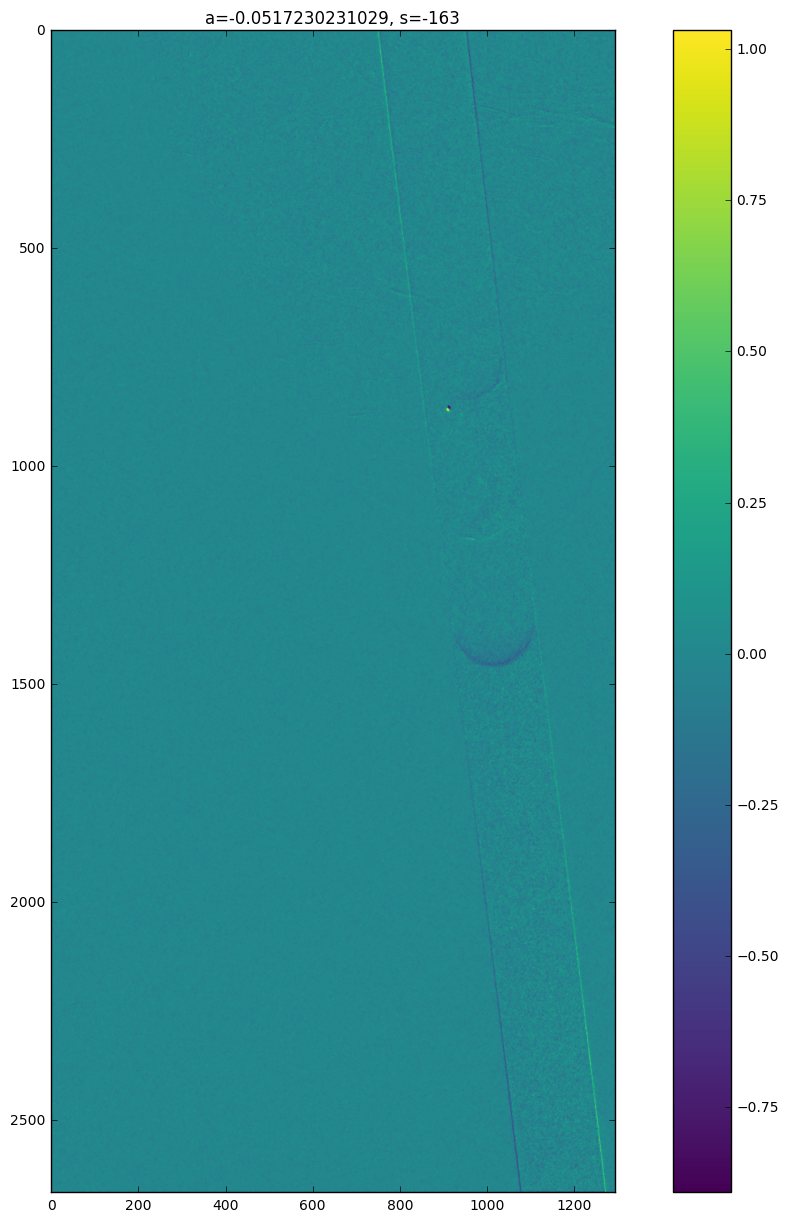

In [25]:
alfa, shift = res.x[0]*10., int(res.x[1])

if shift >= 0:
    t_180 = data_180[:,shift:]
    t_0 = data_0[:,shift:]
else:
    t_180 = data_180[:,:shift]
    t_0 = data_0[:,:shift]
    
tt_180 = np.fliplr(cv_rotate(t_180,alfa))
tt_0 = cv_rotate(t_0,alfa)
    
plt.figure(figsize=(15,15))
plt.imshow(tt_180-tt_0, cmap=plt.cm.viridis)
plt.title('a={}, s={}'.format(alfa,shift))
plt.colorbar()
plt.show()


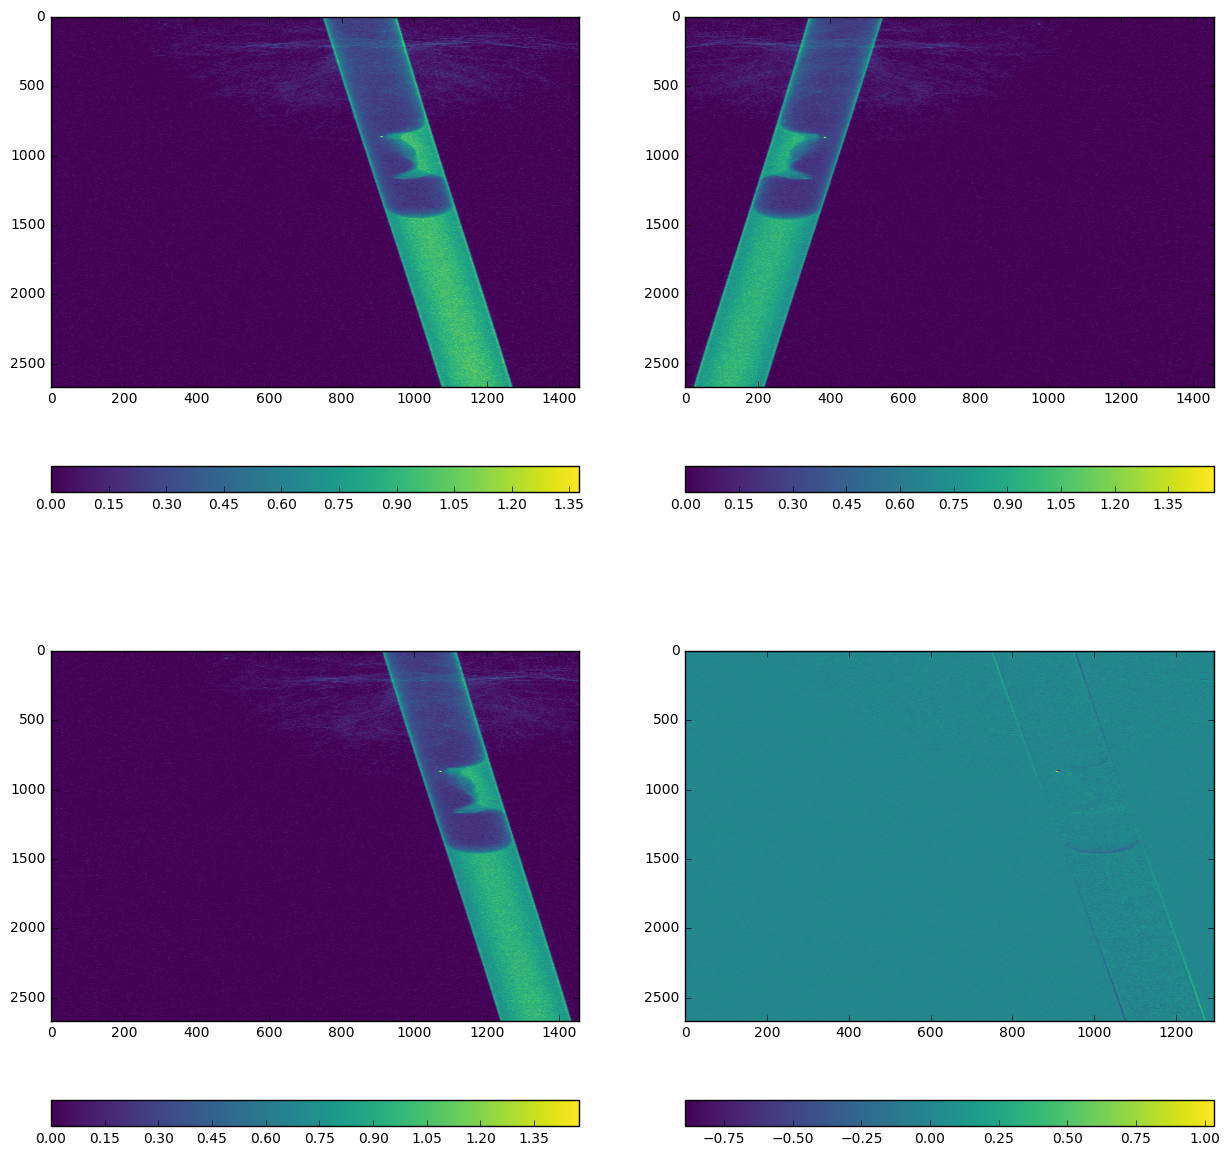

In [26]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(data_0,cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')
plt.subplot(222)
plt.imshow(data_180,cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')
plt.subplot(223)
plt.imshow(np.fliplr(data_180),cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')
plt.subplot(224)
# alfa = 0.1
# shift = -77
plt.imshow(tt_180-tt_0, cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar(orientation='horizontal')

In [27]:
sinogram_fixed = np.zeros(shape=(sinogram.shape[0], sinogram.shape[1]-abs(shift),sinogram.shape[2]),
                                dtype='float32')
#fix axis tlit
for i in range(sinogram.shape[0]):
    if shift >= 0:
        t = cv_rotate(sinogram[i,shift:],alfa)
    else:
        t = cv_rotate(sinogram[i,:shift],alfa)
    sinogram_fixed[i] = t

In [ ]:
print (data_0.shape[1]+shift)/2.

In [49]:
s1 = np.require(sinogram_fixed[:,:,1000],dtype=np.float32, requirements=['C'])`

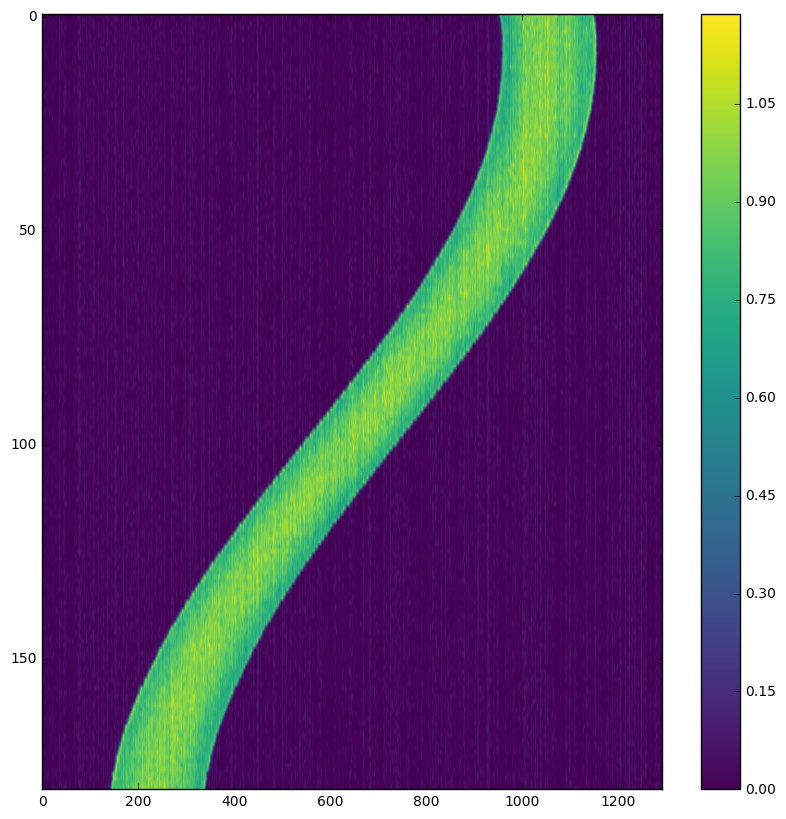

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(s1[np.argsort(uniq_angles)], cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar()
plt.show()

In [47]:
#3d case
# s1 = np.require(sinogram_fixed[:,1220:1221,:].swapaxes(0,1),dtype=np.float32, requirements=['C'])

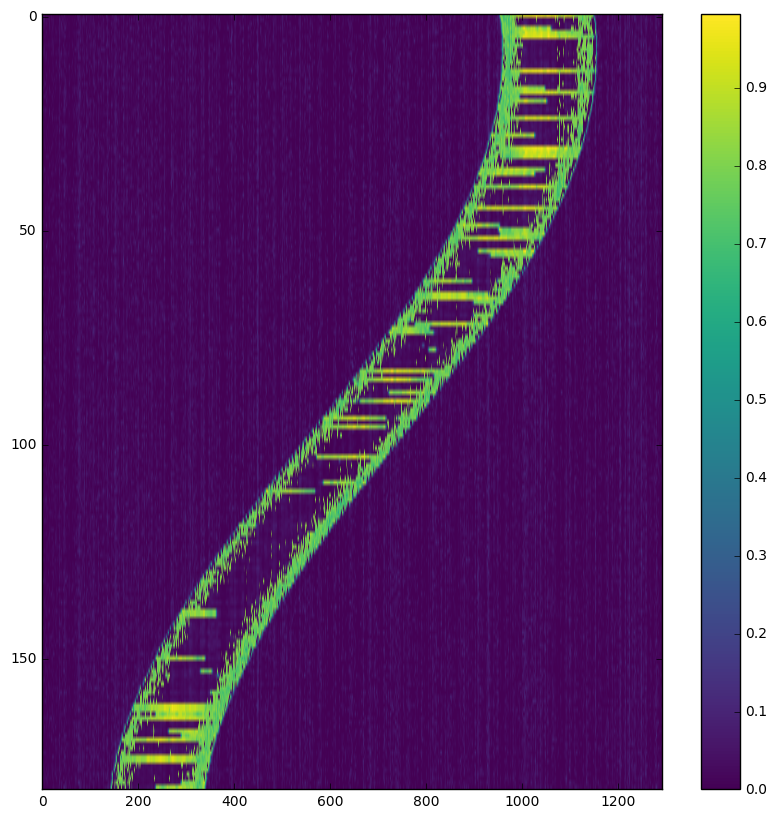

In [48]:
s1_t = np.copy(s1)
mask = s1_t>s1_t.max()*0.7
s1_t[mask] = cv2.medianBlur(s1_t,5)[mask]
plt.figure(figsize=(10,10))
plt.imshow(s1_t[np.argsort(uniq_angles)], cmap=plt.cm.viridis)
plt.axis('tight')
plt.colorbar()
plt.show()

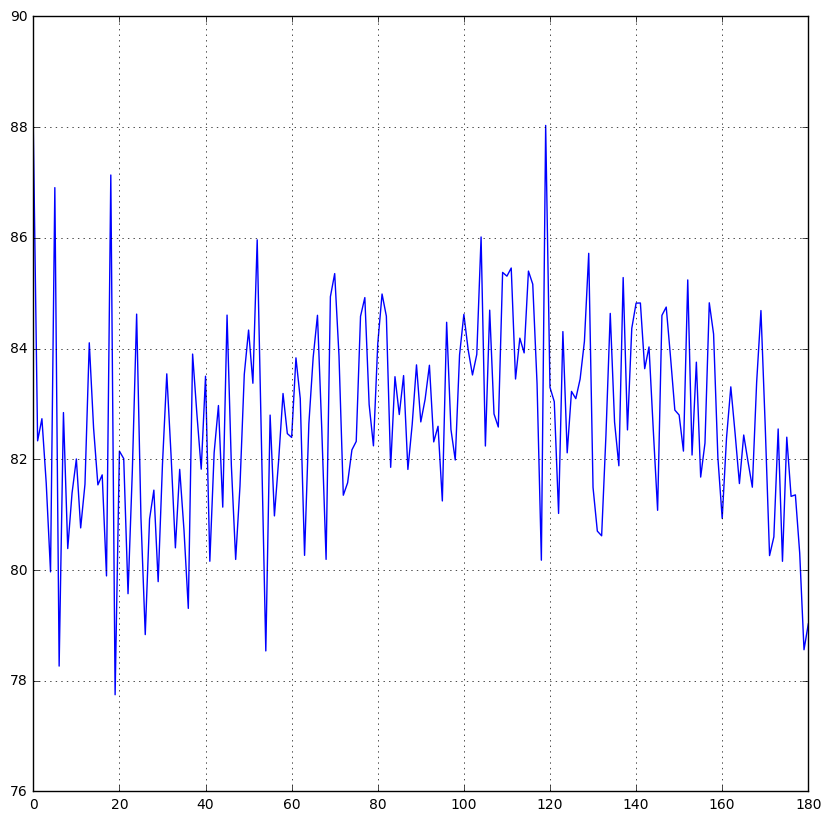

In [34]:
plt.figure(figsize=(10,10))
plt.plot(s1_t[np.argsort(uniq_angles)].sum(axis=-1))
plt.grid()
plt.show()

In [35]:
import astra
def astra_tomo2d_parallel(sinogram, angles):
    angles = angles.astype('float64')
    detector_size = sinogram.shape[1]
    

    rec_size = detector_size
    vol_geom = astra.create_vol_geom(rec_size, rec_size)
    proj_geom = astra.create_proj_geom('parallel', 1.0, detector_size, angles)


    sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinogram)
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)
#     proj_id = astra.create_projector('strip', proj_geom, vol_geom) # for CPU reconstruction only
    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('SART_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
#     cfg['ProjectorId'] = proj_id # for CPU reconstruction only
    cfg['option'] = {}
    cfg['option']['MinConstraint'] = -0.001
    # cfg['option']['MaxConstraint'] = 5

    # Available algorithms:
    # SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA (see the FBP sample)

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id, 1500)

    # Get the result
    rec = astra.data2d.get(rec_id)

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.clear()
    return rec

def astra_tomo3d_parallel(sinogram, angles):
    angles = angles.astype('float64')
    detector_size = sinogram.shape[-1]
    slices_number = sinogram.shape[0]

    rec_size = detector_size
    vol_geom = astra.create_vol_geom(rec_size, rec_size, slices_number)
    proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0,  slices_number, detector_size, angles)

#     print proj_geom
#     print sinogram.shape
    sinogram_id = astra.data3d.create('-sino', proj_geom, data=sinogram)
    # Create a data object for the reconstruction
    rec_id = astra.data3d.create('-vol', vol_geom)
#     proj_id = astra.create_projector('strip', proj_geom, vol_geom) # for CPU reconstruction only
    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('SIRT3D_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
#     cfg['ProjectorId'] = proj_id # for CPU reconstruction only
    cfg['option'] = {}
    #cfg['option']['MinConstraint'] = 0
    # cfg['option']['MaxConstraint'] = 5

    # Available algorithms:
    # SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA (see the FBP sample)

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id, 150)

    # Get the result
    rec = astra.data3d.get(rec_id)

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data3d.delete(rec_id)
    astra.data3d.delete(sinogram_id)
    astra.clear()
    return rec

In [ ]:
s1_t.flags

In [ ]:
%time rec_slice = astra_tomo2d_parallel(s1_t, data_angles*np.pi/180)

In [51]:
rec_slice = astra_tomo2d_parallel(s1, np.array(uniq_angles)*np.pi/180)

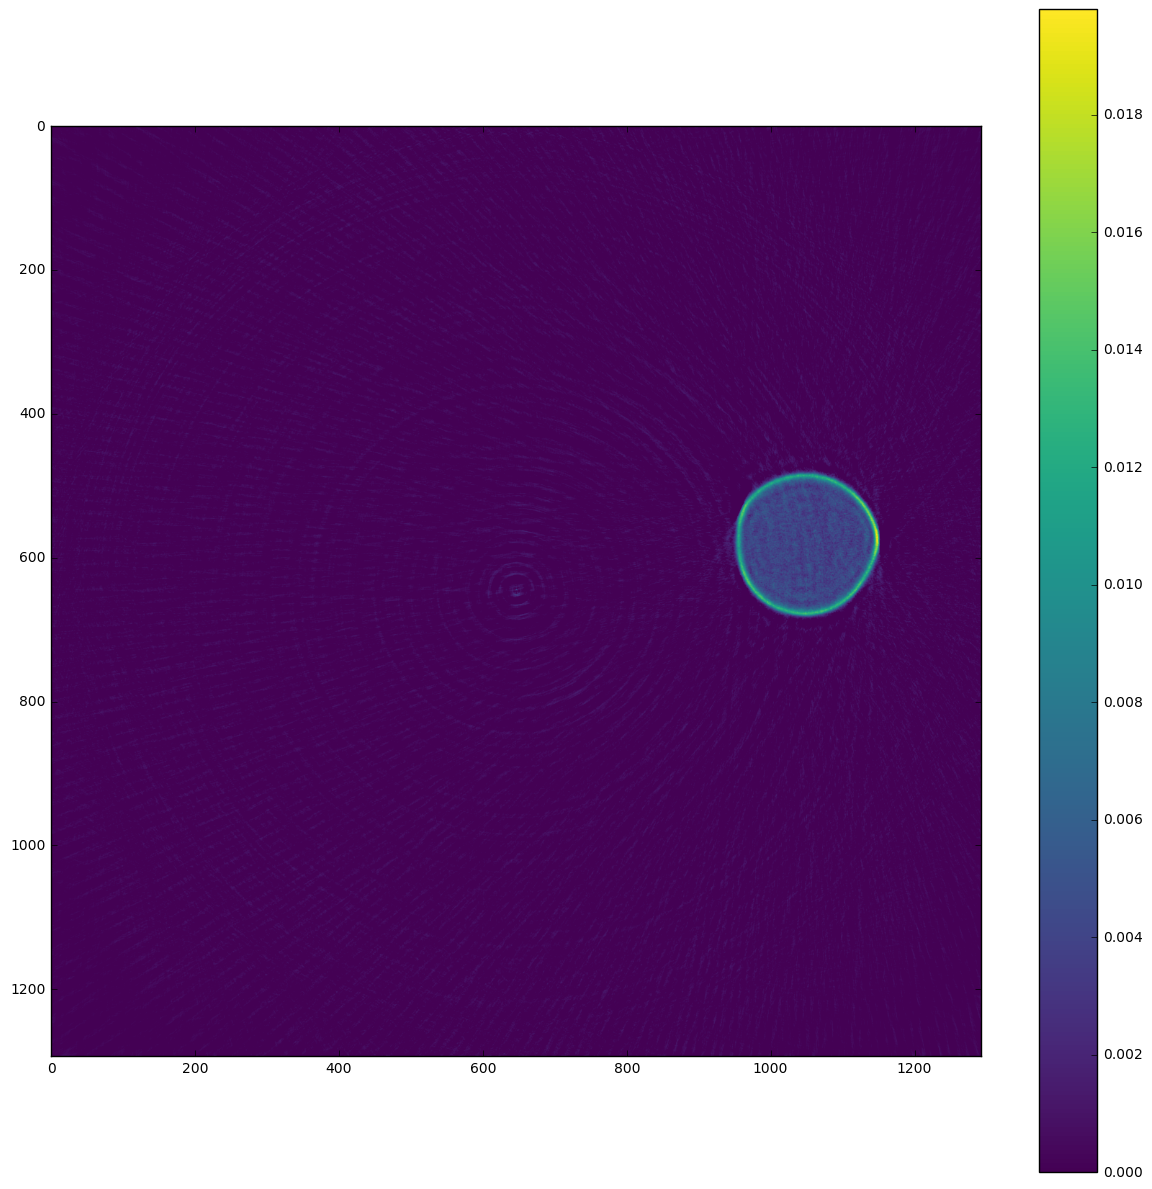

In [52]:
plt.figure(figsize=(15,15))
plt.imshow(rec_slice, cmap=plt.cm.viridis, vmin=0)
plt.colorbar()
plt.show()

In [60]:
res = None
total_slices = sinogram_fixed.shape[-1]
for i in log_progress(range(total_slices)):
    st = np.copy(sinogram_fixed[:,:,i])
#     mask = st>st.max()*0.7
#     st[mask] = cv2.medianBlur(st,5)[mask]
    rec_slice = astra_tomo2d_parallel(st, np.array(uniq_angles)*np.pi/180)
    if res is None:
        res = np.zeros(shape=(total_slices, rec_slice.shape[0], rec_slice.shape[1]),
                       dtype='float32')
    res[i] = rec_slice

In [61]:
data_file_parts = os.path.splitext(data_file)
out_file = '{}_reconstruction.h5'.format(''.join(data_file_parts[:-1]))
print out_file
with h5py.File(out_file,'w') as h5f:
    h5f.create_dataset('Result', data=res[::2,::2,::2], dtype=np.float32)

/diskmnt/fast/makov/robotom/e6fe4ea1-79ef-47bc-bc06-d1d62c4fa03d_reconstruction.h5


In [62]:
def save_amira(result_file):
    """
    Функция сохраняет реконструированные слои в формате Amira raw file

    Inputs:
        data_path - путь к директории, где находиться файл res_tomo.hdf5 в формате HDF5
            в этом файде должен быть раздел (node) /Results в котором в виде 3D массива
            записаны реконструированный объём
    Outputs:
        Файлы amira.raw и tomo.hx. Если файлы уже существуют, то они перезаписываются.
        Тип данных: float32 little endian
    """
    data_path = os.path.dirname(result_file)
    with open(os.path.join(data_path, 'amira.raw'), 'wb') as amira_file:
        with h5py.File(result_file, 'r') as h5f:
            x = h5f['Result']
            for i in range(x.shape[0]):
                np.array(x[i, :, :]).tofile(amira_file)

            file_shape = x.shape

            with open(os.path.join(data_path, 'tomo.hx'), 'w') as af:
                af.write('# Amira Script\n')
                af.write('remove -all\n')
                af.write(r'[ load -raw ${SCRIPTDIR}/amira.raw little xfastest float 1 '+
                         str(file_shape[1])+' '+str(file_shape[2])+' '+str(file_shape[0])+
                         ' 0 '+str(file_shape[1]-1)+' 0 '+str(file_shape[2]-1)+' 0 '+str(file_shape[0]-1)+
                         ' ] setLabel tomo.raw\n')

In [63]:
save_amira(out_file)

In [ ]:
!ls -lah

In [ ]:
out_dir = '/diskmnt/fast/makov/robotom/tmp'
# %mkdir out_dir
plt.figure(figsize=(10,10))
for idi,i in log_progress(list(enumerate(np.argsort(data_angles)))):
    plt.imsave(os.path.join(out_dir,'{:03}.png'.format(idi)),
                cv2.resize(data_beam[i],tuple(np.array(data_beam[i].shape)//2)), cmap=plt.cm.gray)

In [ ]:
!avconv -i '/diskmnt/fast/makov/robotom/tmp/%03d.png' -c:v libx264 -r 30  '/diskmnt/fast/makov/robotom/tmp/out.mp4'

In [ ]:
!rm '/diskmnt/fast/makov/robotom/tmp/out.mp4'
!avconv -framerate 25 -i '/diskmnt/fast/makov/robotom/tmp/%03d.png' -c:v h264 -crf 1 '/diskmnt/fast/makov/robotom/tmp/out.mp4'

In [ ]:
!rm '/diskmnt/fast/makov/robotom/tmp/out.mp4'
!avconv -i '/diskmnt/fast/makov/robotom/tmp/%03d.png' '/diskmnt/fast/makov/robotom/tmp/out.mp4'